# 1. Introduction
- In this example, we use harmonic lattice dynamics to calculate the phonon dispersion of graphene and visualize its lattice vibration information.

# 2. Phonon dispersion 
## 2.1 Importing Relevant Functions
- The inputs/outputs for GPUMD are processed using the [Atomic Simulation Environment (ASE)](https://wiki.fysik.dtu.dk/ase/) and the [thermo](https://github.com/AlexGabourie/thermo) package. 

In [28]:
from pylab import *
from ase.io import read
from thermo.gpumd.preproc import add_basis, repeat
from thermo.gpumd.io import create_basis, create_kpoints, ase_atoms_to_gpumd
from thermo.gpumd.data import load_omega2

## 2. 2 Preparting the Inputs
- The structure as specified is 50-atom graphene at zero temperature and zero pressure. 
- We use a Tersoff potential [[Tersoff 1989]](https://doi.org/10.1103/PhysRevB.39.5566) parameterized by Lindsay *et al.* [[Lindsay 2010]](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.81.205441).
- Note that the thickness of the graphene sheet is set to 3.35 $\mathring A$ according to the convention in the literature. This thickness is needed to calculate an effective 3D thermal conductivity for a 2D material.

### Generate the  [xyz.in](https://gpumd.zheyongfan.org/index.php/The_xyz.in_input_file) file:
#### Create graphene Unit Cell & Add Basis

In [29]:
gr_uc = read("gr_uc.vasp")
gr_uc.center()
gr_uc.pbc = [True, True, False]
add_basis(gr_uc)
gr_uc

Atoms(symbols='C2', pbc=[True, True, False], cell=[[2.4604399204, 0.0, 0.0], [-1.2302199602, 2.1308034756, 0.0], [0.0, 0.0, 10.0]])

#### Create graphene supercell

In [30]:
gr = repeat(gr_uc, [5,5,1])
gr

Atoms(symbols='C50', pbc=[True, True, False], cell=[[12.302199601999998, 0.0, 0.0], [-6.151099800999999, 10.654017378, 0.0], [0.0, 0.0, 10.0]])

### Write [xyz.in](https://gpumd.zheyongfan.org/index.php/The_xyz.in_input_file) File

In [31]:
ase_atoms_to_gpumd(gr, M=3, cutoff=2.1)

C:\Users\hityingph\anaconda3\lib\site-packages\ase\utils\__init__.py:62: FutureWarning: Please use atoms.cell.cellpar() instead
  warnings.warn(warning)


### Write lammps.data File

In [41]:
write("lammps.data", gr, "lammps-data")

### Write [basis.in](https://gpumd.zheyongfan.org/index.php/The_basis.in_input_file) File
- The [basis.in](https://gpumd.zheyongfan.org/index.php/The_basis.in_input_file) file reads:
```
2
0 28
4 28
0
0
0
0
1
1
1
1
...
```
- Here the primitive cell is chosen as the unit cell. There are only two basis atoms in the unit cell, as indicated by the number 2 in the first line.

- The next two lines list the indices (0 and 4) and masses (both are 28 amu) for the two basis atoms.

- The next lines map all the atoms (including the basis atoms) in the super cell to the basis atoms: atoms equivalent to atom 0 have a label 0, and atoms equivalent to atom 1 have a label 1.

**Note:** The [basis.in](https://gpumd.zheyongfan.org/index.php/The_basis.in_input_file) file generated by this Jupyter notebook may look different, but the same concepts apply and the results will be the same.

In [33]:
create_basis(gr)

### Write [kpoints.in](https://gpumd.zheyongfan.org/index.php/The_kpoints.in_input_file) File
- The $k$ vectors are defined in the reciprocal space with respect to the unit cell chosen in the [basis.in](https://gpumd.zheyongfan.org/index.php/The_basis.in_input_file) file.
- We use the $\Gamma-M-K-\Gamma$ path, with 400 $k$ points in total.

In [34]:
linear_path, sym_points, labels = create_kpoints(gr_uc, path='GMKG',npoints=400)

C:\Users\hityingph\anaconda3\lib\site-packages\ase\utils\__init__.py:62: FutureWarning: Please use atoms.cell.reciprocal()
  warnings.warn(warning)


## The <code>run.in</code> file:
The <code>run.in</code> input file is given below:<br>
```
potential       potentials/tersoff/Si_Fan_2019.txt 0
compute_phonon  5.0 0.005 # in units of A
```

- The first line with the [potential](https://gpumd.zheyongfan.org/index.php/The_potential_keyword) keyword states that the potential to be used is specified in the file [Si_Fan_2019.txt](https://github.com/brucefan1983/GPUMD/blob/master/potentials/tersoff/Si_Fan_2019.txt).

- The second line with the [compute_phonon](https://gpumd.zheyongfan.org/index.php/The_compute_phonon_keyword) keyword tells that the force constants will be calculated with a cutoff of 5.0 $\mathring A$ (here the point is that first and second nearest neighbors need to be included) and a displacement of 0.005 $\mathring A$ will be used in the finite-displacement method.

## 2.3 Results and Discussion

### Figure Properties

In [35]:
aw = 2
fs = 24
font = {'size'   : fs}
matplotlib.rc('font', **font)
matplotlib.rc('axes' , linewidth=aw)

def set_fig_properties(ax_list):
    tl = 8
    tw = 2
    tlm = 4
    
    for ax in ax_list:
        ax.tick_params(which='major', length=tl, width=tw)
        ax.tick_params(which='minor', length=tlm, width=tw)
        ax.tick_params(which='both', axis='both', direction='in', right=True, top=True)

### Plot Phonon Dispersion
- The [omega2.out](https://gpumd.zheyongfan.org/index.php/The_omega2.out_output_file) output file is loaded and processed to create the following figure. The previously defined kpoints are used for the $x$-axis.

In [36]:
nu = load_omega2()

C:\Users\hityingph\anaconda3\lib\site-packages\thermo-0.3-py3.8.egg\thermo\gpumd\data.py:205: RuntimeWarning: invalid value encountered in sqrt
  data = np.sqrt(data)/(2*np.pi)


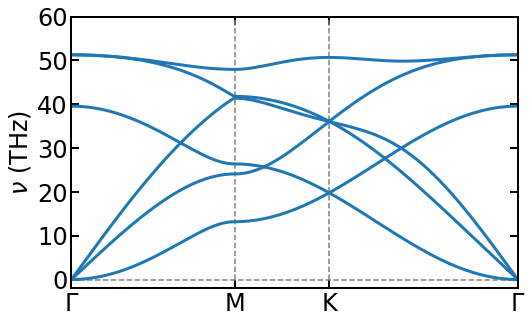

In [37]:
figure(figsize=(8,5))
set_fig_properties([gca()])
vlines(sym_points, ymin=0, ymax=60, color="grey", linestyle="--")
hlines(0, xmin=0, xmax=5, color="grey", linestyle="--")
plot(linear_path, nu, color='C0',lw=3)
xlim([0, max(linear_path)])
gca().set_xticks(sym_points)
gca().set_xticklabels([r'$\Gamma$','M', 'K', r'$\Gamma$'])
ylim([-2, 60])
gca().set_yticks(linspace(0, 60, 7))
ylabel(r'$\nu$ (THz)')
show()

# 3. Visualizing lattice vibration information
## 3.1 Eigenvector.out (generate by [GPUMD](https://gpumd.zheyongfan.org/index.php/The_eigenvector.in_input_file))

With the [eigenvector.out](https://gpumd.zheyongfan.org/index.php/The_eigenvector.in_input_file) file generated by GPUMD, we can obtain the eigenvector at $\Gamma$ points for their visualization on the atoms. The input and out files are provided in the path of "Eigenvector.out".

Please see the [GPUMD manual](https://gpumd.zheyongfan.org/index.php/The_eigenvector.in_input_file) for how to generate eigenvector.out. If you not only want to visualize the eigenvectors of $\Gamma$ point, you can diagonalize the [D.out](https://gpumd.zheyongfan.org/index.php/The_D.out_output_file) file by yourself.

* **Tips:** One can only modify the Kpoints.in file in following way：
    ```
    1
    0 0 0
    
    ```
  Thus, only one kpoint is included to this file. Then, one can rerun the GPUMD to obtain the [eigenvector.out](https://gpumd.zheyongfan.org/index.php/The_eigenvector.in_input_file).
  
  Second, the number of atoms in the simulation model is equal to the number of basis atoms. This means the preparation of the basis.in file becomes straightforward. In this case, the basis.in file will look like:
```
  50	
0	12.011
1	12.011
2	12.011
3	12.011
...
47	12.011
48	12.011
49	12.011
0
1
2
3
...
47
48
49
``` 
  
  
* **The size of [eigenvector.out](https://gpumd.zheyongfan.org/index.php/The_eigenvector.in_input_file) file is small because only the eigenvectors of $\Gamma$ point are output. Therefore, one can choose a structure with very large atom in unit cell for calculation.**

## 3.2 View (generate the [lammps dump.file](https://docs.lammps.org/dump.html) and feed to [Ovito](https://www.ovito.org/about/))

### Run the [view_eigen_gpumd.py](https://github.com/Tingliangstu/Phonon-Vibration-Viewer/blob/main/calculate%20phonon%20dispersion/view_eigen_gpumd.py) file
* Here, we will used the [view_eigen_gpumd.py](https://github.com/Tingliangstu/Phonon-Vibration-Viewer/blob/main/calculate%20phonon%20dispersion/view_eigen_gpumd.py) file to process the [eigenvector.out](https://gpumd.zheyongfan.org/index.php/The_eigenvector.in_input_file) file and to generate the [dump.file](https://docs.lammps.org/dump.html) . 


* The package [Atomic Simulation Environment (ASE)](https://wiki.fysik.dtu.dk/ase/) is used here to generate the dump file including two frames with format of lammps-data, while the first frame being the original atomic coordinates. The second frame is the atomic coordinates with the eigenvectors (**plus**). Thus, using ovtio's [Displacement vectors](https://www.ovito.org/docs/current/reference/pipelines/modifiers/displacement_vectors.html?highlight=displacement) feature, we can visualize the eigenvectors.  


* In the following, we will describe two simple parameters that need to be modified in the [view_eigen_gpumd.py](https://github.com/Tingliangstu/Phonon-Vibration-Viewer/blob/main/calculate%20phonon%20dispersion/view_eigen_gpumd.py). 

In [38]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
Visualizing lattice vibration information from phonon dispersion for primitive atoms
Developed initially by Liang Ting in2021/12/18
Revised by Ying Penghua in 2022/2/50
"""

import numpy as np
import os
from ase.io.lammpsdata import read_lammps_data, write_lammps_data

def get_frequency_eigen_info(num_basis, eig_file='eigenvector.out', directory=None):
    if not directory:
        eig_path = os.path.join(os.getcwd(), eig_file)
    else:
        eig_path = os.path.join(directory, eig_file)

    eig_data_file = open(eig_path, 'r')
    data_lines = [line for line in eig_data_file.readlines() if line.strip()]
    eig_data_file.close()

    om2 = np.array([data_lines[0].split()[0:num_basis * 3]], dtype='float64')
    eigenvector = np.array([data_lines[1 + k].split()[0:num_basis * 3]
                                               for k in range(num_basis * 3)], dtype='float64')
    nu = np.sign(om2) * np.sqrt(abs(np.array(om2))) / (2 * np.pi)
    return nu, eigenvector

def position_plus_eigen(gamma_freq_points, nu, eigenvector, atom_num_in_box):
    if atom_num_in_box * 3 != np.size(eigenvector, 1):
        raise ValueError("The data dimension of the eigenvector is inconsistent with atomic number*3")
    print('************* Now the frequency is {:0.5f} THz, the visualization of the eigenvectors is at gamma point'
          '**************** '.format(nu[0][gamma_freq_points]))

    eigenvector_x = eigenvector[gamma_freq_points][0:atom_num_in_box]
    eigenvector_y = eigenvector[gamma_freq_points][atom_num_in_box:atom_num_in_box*2]
    eigenvector_z = eigenvector[gamma_freq_points][atom_num_in_box*2:atom_num_in_box*3]
    eigenvector_xyz = np.c_[eigenvector_x, eigenvector_y, eigenvector_z]
    return eigenvector_xyz

if __name__ == "__main__":

    num_basis = int(input("Number of basis atoms: ")) #50
    gamma_freq_points = int(input("The nth frequency point at Gamma point: ")) #from 0 
    nu, eigenvector = get_frequency_eigen_info(num_basis)
    
    first_frame = read_lammps_data('lammps.data', style='atomic')
    positions_first_frame = first_frame.get_positions()
    atom_num_in_box = len(positions_first_frame)
    direct_cell = first_frame.cell[:]
    second_frame = read_lammps_data('lammps.data', style='atomic')
    positions_delta = position_plus_eigen(gamma_freq_points, nu, eigenvector, atom_num_in_box)
    positions_second_frame = positions_first_frame + positions_delta
    second_frame.set_positions(positions_second_frame)
    write_lammps_data("Phonon_{:0.5f}THz_first_frame.data".format(nu[0][gamma_freq_points]), first_frame)
    write_lammps_data("Phonon_{:0.5f}THz_second_frame.data".format(nu[0][gamma_freq_points]), second_frame)
    
    print('******************** All Done !!! *************************')

Number of basis atoms: 50
The nth frequency point at Gamma point: 100
************* Now the frequency is 39.73067 THz, the visualization of the eigenvectors is at gamma point**************** 
******************** All Done !!! *************************


* **num_basis = 50** 

    This means that there are 50 atoms in the unitcell of graphene (5$\times$5$\times$1 supercell). 
    

* **gamma_freq_points = 1**

    The 1-th frequency point on the $\Gamma$ point, depending on which frequency point you want to visualize.

Here, two frames, i.e., first frame and second frame with the frequency name ("Phonon_39.73067THz_first_frame.data" and "Phonon_39.73067THz_second_frame.data") in the format of lammps data file would be generate. Then, one can use it to view the lattice vibration by using [OVITO](https://www.ovito.org/). Specifically, the feature of [Displacement vectors](https://www.ovito.org/docs/current/reference/pipelines/modifiers/displacement_vectors.html?highlight=displacement) in OVITO is used, in which one can calculate the relative atomic displacement between first frame and second frame and eventually get the diagram shown below.

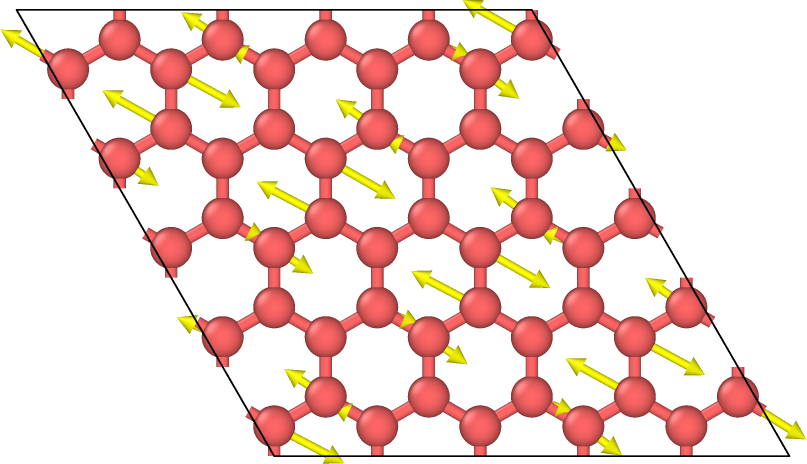